# Code for the paper Saldaña, Camacho, Villavicencio, Velasco

First, some notation to reduce the code size.

State variables
---
$x01 = S_f\\
x02 = S_m\\
x03 = V_f\\
x04 = V_m\\
x05 = A_f\\
x06 = A_m\\
x07 = I_f\\
x08 = I_m\\
x09 = P_f\\
x10 = P_m\\
x11 = C_f\\
x12 = C_m$

Parameters
---
$p01 = \Lambda_f\\
p02 = \Lambda_m\\
p03 = \mu_f\\
p04 = \mu_m\\
p05 = q_A^f\\
p06 = q_A^m\\
p07 = k_A^f\\
p08 = k_A^m\\
p09 = q_I^f\\
p10 = q_I^m\\
p11 = k_I^f\\
p12 = k_I^m\\
p13 = q_P^f\\
p14 = q_P^m\\
p15 = k_P^f\\
p16 = k_P^m\\
p17 = \theta_f\\
p18 = \theta_m\\
p19 = \delta_f\\
p20 = \delta_m\\
p21 = \beta_A^f\\
p22 = \beta_A^m\\
p23 = \beta_I^f\\
p24 = \beta_I^m$

Auxiliar functions
---
$f01 = \lambda_f = (\beta_A^f*A_f + \beta_I^f*I_f)/N_f,\\
f02 = \lambda_m = (\beta_A^m*A_m + \beta_I^m*I_m)/N_m$

Control variables
---
$u1 = w_f\\
u2 = w_m\\
u3 = u_f\\
u4 = u_m$

In [1]:
import numpy as np
from scipy.integrate import odeint, ode
from matplotlib import pyplot as plt

In [2]:
# Runge-Kutta forward
def runge_forward(State, Control):
    x = State
    u = Control
    
    for i in range(NN-1):
        u_mid = 0.5*(u[:,i]+u[:,i+1])
        
        k1 = model( x[:,i],          i,       u[:,i] )
        k2 = model( x[:,i]+h*0.5*k1, i+0.5*h, u_mid)
        k3 = model( x[:,i]+h*0.5*k2, i+0.5*h, u_mid)
        k4 = model( x[:,i]+h*k3,     i+h,     u[:,i+1])
        
        x[:,i+1] = x[:,i] + h*(k1+2.0*k2+2.0*k3+k4)/6.0
    return x

# Runge-Kutta backward
def runge_backward(State, Control, Adjoint):
    x = State
    u = Control
    l = Adjoint
    
    for i in range(NN-1,0,-1):
        u_mid = 0.5*( u[:,i]+u[:,i-1] )
        x_mid = 0.5*( x[:,i]+x[:,i-1] )
        
        k1 = glambda( x[:,i],   i,       u[:,i],   l[:,i])
        k2 = glambda( x_mid,    i-0.5*h, u_mid,    l[:,i]-h*0.5*k1)
        k3 = glambda( x_mid,    i-0.5*h, u_mid,    l[:,i]-h*0.5*k2)
        k4 = glambda( x[:,i-1], i-h,     u[:,i-1], l[:,i]-h*k3)
        
        l[:,i-1] = l[:,i] - h*(k1+2.0*k2+2.0*k3+k4)/6.0
    return l

In [3]:
# Model
def model(State, t, Control):
    # State variables
    x01 = State[0]
    x02 = State[1]
    x03 = State[2]
    x04 = State[3]
    x05 = State[4]
    x06 = State[5]
    x07 = State[6]
    x08 = State[7]
    x09 = State[8]
    x10 = State[9]
    x11 = State[10]
    x12 = State[11]
    
    # Control variables
    u1 = Control[0]
    u2 = Control[1]
    u3 = Control[2]
    u4 = Control[3]
    
    # Auxiliar
    Nf = x01 + x03 + x05 + x07 + x09 + x11
    Nm = x02 + x04 + x06 + x08 + x10 + x12
    f01 = p21*x05/Nf + p23*x07/Nf
    f02 = p22*x06/Nm + p24*x08/Nm
    
    # ODEs
    ode1 = (1-u1)*p01 - (f02+u3+p03)*x01 + p05*p07*x05 + p09*p11*x07 + p13*p15*x09 + p17*x03

    ode2 = (1-u2)*p02 - (f01+u4+p04)*x02 + p06*p08*x06 + p10*p12*x08 + p14*p16*x10 + p18*x04

    ode3 = u1*p01 + u3*x01 - (p03+p17)*x03

    ode4 = u2*p02 + u4*x02 - (p04+p18)*x04

    ode5 = f02*x01 - (p07+p03)*x05

    ode6 = f01*x02 - (p08+p04)*x06

    ode7 = (1-p05)*p07*x05 - (p11+p03)*x07

    ode8 = (1-p06)*p08*x06 - (p12+p04)*x08

    ode9 = (1-p09)*p11*x07 - (p15+p03)*x09

    ode10 = (1-p10)*p12*x08 - (p16+p04)*x10

    ode11 = (1-p13)*p15*x09 - (p19+p03)*x11

    ode12 = (1-p14)*p16*x10 - (p20+p04)*x12
    
    odes = np.array([ode1, ode2, ode3,
                     ode4, ode5, ode6,
                     ode7, ode8, ode9,
                     ode10, ode11, ode12])
    return odes

In [4]:
# Adjoint system
def glambda(State, t, Control, Adjoint):    
    # State variables
    x01 = State[0]
    x02 = State[1]
    x03 = State[2]
    x04 = State[3]
    x05 = State[4]
    x06 = State[5]
    x07 = State[6]
    x08 = State[7]
    x09 = State[8]
    x10 = State[9]
    x11 = State[10]
    x12 = State[11]
    
    # Control variables
    u1 = Control[0]
    u2 = Control[1]
    u3 = Control[2]
    u4 = Control[3]
    
    # Adjoint variables
    l01 = Adjoint[0]
    l02 = Adjoint[1]
    l03 = Adjoint[2]
    l04 = Adjoint[3]
    l05 = Adjoint[4]
    l06 = Adjoint[5]
    l07 = Adjoint[6]
    l08 = Adjoint[7]
    l09 = Adjoint[8]
    l10 = Adjoint[9]
    l11 = Adjoint[10]
    l12 = Adjoint[11]
    
    # Auxiliar
    Nf = x01 + x03 + x05 + x07 + x09 + x11
    Nm = x02 + x04 + x06 + x08 + x10 + x12
    f01 = p21*x05/Nf + p23*x07/Nf
    f02 = p22*x06/Nm + p24*x08/Nm
    
    # ODEs
    ode1 = -l01*(-p03 - p22*x06/(x02 + x04 + x06 + x08 + x10 + x12) - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12) - u3) + l02*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l03*u3 - l05*(p22*x06/(x02 + x04 + x06 + x08 + x10 + x12) + p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)) - l06*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2)
    
    ode2 = l01*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l02*(-p04 - p21*x05/(x01 + x03 + x05 + x07 + x09 + x11) - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11) - u4) - l04*u4 - l05*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l06*(p21*x05/(x01 + x03 + x05 + x07 + x09 + x11) + p23*x07/(x01 + x03 + x05 + x07 + x09 + x11))

    ode3 = -l01*p17 + l02*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l03*(-p03 - p17) - l06*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2)

    ode4 = l01*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l02*p18 - l04*(-p04 - p18) - l05*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2)

    ode5 = -l01*p05*p07 + l02*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 + p21/(x01 + x03 + x05 + x07 + x09 + x11) - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l05*(-p03 - p07) - l06*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 + p21/(x01 + x03 + x05 + x07 + x09 + x11) - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l07*p07*(1 - p05)

    ode6 = l01*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 + p22/(x02 + x04 + x06 + x08 + x10 + x12) - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l02*p06*p08 - l05*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 + p22/(x02 + x04 + x06 + x08 + x10 + x12) - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l06*(-p04 - p08) - l08*p08*(1 - p06)

    ode7 = -B1 - l01*p09*p11 + l02*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2 + p23/(x01 + x03 + x05 + x07 + x09 + x11)) - l06*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2 + p23/(x01 + x03 + x05 + x07 + x09 + x11)) - l07*(-p03 - p11) - l09*p11*(1 - p09)

    ode8 = -B2 + l01*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2 + p24/(x02 + x04 + x06 + x08 + x10 + x12)) - l02*p10*p12 - l05*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2 + p24/(x02 + x04 + x06 + x08 + x10 + x12)) - l08*(-p04 - p12) - l10*p12*(1 - p10)

    ode9 = -B3 - l01*p13*p15 + l02*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l06*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l09*(-p03 - p15) - l11*p15*(1 - p13)

    ode10 = -B4 + l01*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l02*p14*p16 - l05*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l10*(-p04 - p16) - l12*p16*(1 - p14)

    ode11 = -B5 + l02*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l06*x02*(-p21*x05/(x01 + x03 + x05 + x07 + x09 + x11)**2 - p23*x07/(x01 + x03 + x05 + x07 + x09 + x11)**2) - l11*(-p03 - p19)

    ode12 = -B6 + l01*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l05*x01*(-p22*x06/(x02 + x04 + x06 + x08 + x10 + x12)**2 - p24*x08/(x02 + x04 + x06 + x08 + x10 + x12)**2) - l12*(-p04 - p20)

    
    
    odes = np.array([ode1, ode2, ode3,
                     ode4, ode5, ode6,
                     ode7, ode8, ode9,
                     ode10, ode11, ode12])
    return odes

In [5]:
def control_new(State, Adjoint, Control, iteration, uMax):
    # State variables
    x01 = State[0]
    x02 = State[1]
    x03 = State[2]
    x04 = State[3]
    x05 = State[4]
    x06 = State[5]
    x07 = State[6]
    x08 = State[7]
    x09 = State[8]
    x10 = State[9]
    x11 = State[10]
    x12 = State[11]
    
    # Control variables
    u1 = Control[0]
    u2 = Control[1]
    u3 = Control[2]
    u4 = Control[3]
    
    # Adjoint variables
    l01 = Adjoint[0]
    l02 = Adjoint[1]
    l03 = Adjoint[2]
    l04 = Adjoint[3]
    l05 = Adjoint[4]
    l06 = Adjoint[5]
    l07 = Adjoint[6]
    l08 = Adjoint[7]
    l09 = Adjoint[8]
    l10 = Adjoint[9]
    l11 = Adjoint[10]
    l12 = Adjoint[11]
    
    # Auxiliar
    Nf = x01 + x03 + x05 + x07 + x09 + x11
    Nm = x02 + x04 + x06 + x08 + x10 + x12
    f01 = p21*x05/Nf + p23*x07/Nf
    f02 = p22*x06/Nm + p24*x08/Nm
    
    u1up = np.zeros_like(l01)
    u2up = np.zeros_like(l01)
    u3up = np.zeros_like(l01)
    u4up = np.zeros_like(l01)
    
    # Max control
    u1max = uMax[0]
    u2max = uMax[1]
    u3max = uMax[2]
    u4max = uMax[3]
    
    for ii in range(len(l01)): # *CHECK!*
        u1up[ii] = np.max([np.min( [p01*(l01[ii] - l03[ii])/A1, u1max]), 0])
        u2up[ii] = np.max([np.min( [p02*(l02[ii] - l04[ii])/A2, u2max]), 0])
        u3up[ii] = np.max([np.min( [x01[ii]*(l01[ii] - l03[ii])/A3, u3max]), 0])
        u4up[ii] = np.max([np.min( [x02[ii]*(l02[ii] - l04[ii])/A4, u4max]), 0])
    
    New_Control = np.array([u1up,u2up,u3up,u4up])
    
    # We should take the average of the old and new controls to improve convergence
    #Updated_Control = (1-4/(4+iteration))*Control + (1-(1-4/(4+iteration)))*New_Control
    Updated_Control = 0.9*Control + 0.1*New_Control
    
    return Updated_Control

## Model parameters

In [6]:
# ODE parameters
Nf0 = 3352419
Nm0 = 3094541
# Total: ~ 6*10^6

p01 = 17097 # Lambda_f
p02 = 15782 # Lambda_m

p03 = 1/40 # mu_f
p04 = 1/50 # mu_m

p05 = 0.6 # q_A^f
p06 = 0.8 # q_A^m

p07 = 1 # k_A^f
p08 = 1 # k_A^m

p09 = 0.8 # q_I^f
p10 = 0.9 # q_I^m

p11 = 1/0.81 # k_I^f
p12 = 1/0.62 # k_I^m

p13 = 0.4 # q_P^f
p14 = 0.9 # q_P^m

p15 = 1/15 # k_P^f
p16 = 1/15 # k_P^m

p17 = 1/25 # theta_f
p18 = 1/25 # theta_m

p19 = 0.01 # delta_f
p20 = 0.005 # delta_m

p21 = 2.5 # beta_A^f
p22 = 2.0 # beta_A^m

p23 = 5.0 # beta_I^f
p24 = 4.0 # beta_I^m

# Temporal parameters
T  = 20.                  # Final Time
NN = int(10*T)            # sub-intervals numbers
t  = np.linspace(0, T, NN) # Interval [0,T] with N points
h  = float(T)/float(NN)    # Time step

# Initial condition sets
Vf0 = 0.1*Nf0
Vm0 = 0
If0 = 0.01*Nf0
Im0 = 0.01*Nm0
Af0 = 0.05*Nf0
Am0 = 0.05*Nm0
Pf0 = 0.001*Nf0
Pm0 = 0.001*Nm0
Cf0 = 0.0001*Nf0
Cm0 = 0.0001*Nm0
Sf0 = Nf0-Vf0-Af0-If0-Pf0-Cf0
Sm0 = Nm0-Vm0-Am0-Im0-Pm0-Cm0

Sf0ar = np.zeros(NN)
Sf0ar[0] = Sf0

Sm0ar = np.zeros(NN)
Sm0ar[0] = Sm0

Vf0ar = np.zeros(NN)
Vf0ar[0] = Vf0

Vm0ar = np.zeros(NN)
Vm0ar[0] = Vm0

Af0ar = np.zeros(NN)
Af0ar[0] = Af0

Am0ar = np.zeros(NN)
Am0ar[0] = Am0

If0ar = np.zeros(NN)
If0ar[0] = If0

Im0ar = np.zeros(NN)
Im0ar[0] = Im0

Pf0ar = np.zeros(NN)
Pf0ar[0] = Pf0

Pm0ar = np.zeros(NN)
Pm0ar[0] = Pm0

Cf0ar = np.zeros(NN)
Cf0ar[0] = Cf0

Cm0ar = np.zeros(NN)
Cm0ar[0] = Cm0

State0 = np.array([Sf0ar, Sm0ar, Vf0ar, Vm0ar, 
                   Af0ar, Am0ar, If0ar, Im0ar, 
                   Pf0ar, Pm0ar, Cf0ar, Cm0ar])

u1 = np.zeros(NN)
u2 = np.zeros(NN)
u3 = np.zeros(NN)
u4 = np.zeros(NN)

Control0 = np.array([u1, u2, u3, u4])

Adjoint0 = np.zeros_like(State0) 

### Control scenario I (A1= A2= A3=A4)

In [7]:
print(-np.log(0.2))

1.6094379124341003


In [8]:
# Max Control
uMax = [0.7, 0.7, 1.6, 1.6]

# Weight parameters
A1 = 1e5
A2 = 1e5
A3 = 1e5
A4 = 1e5

# Scenario 1
B1 = 1e5  # B1*If
B2 = 0    # B2*Im
B3 = 8*B1 # B3*Pf
B4 = 0    # B4*Pm
B5 = 6*B3 # B5*Cf
B6 = 0    # B6*Cm

u1 = np.zeros(NN)
u2 = np.zeros(NN)
u3 = np.zeros(NN)
u4 = np.zeros(NN)

Control0 = np.array([u1, u2, u3, u4])

Adjoint0 = np.zeros_like(State0) 

# Initial condition sets
Vf0 = 0.1*Nf0
Vm0 = 0
If0 = 0.01*Nf0
Im0 = 0.01*Nm0
Af0 = 0.05*Nf0
Am0 = 0.05*Nm0
Pf0 = 0.001*Nf0
Pm0 = 0.001*Nm0
Cf0 = 0.0
Cm0 = 0.0
Sf0 = Nf0-Vf0-Af0-If0-Pf0-Cf0
Sm0 = Nm0-Vm0-Am0-Im0-Pm0-Cm0

Sf0ar = np.zeros(NN)
Sf0ar[0] = Sf0

Sm0ar = np.zeros(NN)
Sm0ar[0] = Sm0

Vf0ar = np.zeros(NN)
Vf0ar[0] = Vf0

Vm0ar = np.zeros(NN)
Vm0ar[0] = Vm0

Af0ar = np.zeros(NN)
Af0ar[0] = Af0

Am0ar = np.zeros(NN)
Am0ar[0] = Am0

If0ar = np.zeros(NN)
If0ar[0] = If0

Im0ar = np.zeros(NN)
Im0ar[0] = Im0

Pf0ar = np.zeros(NN)
Pf0ar[0] = Pf0

Pm0ar = np.zeros(NN)
Pm0ar[0] = Pm0

Cf0ar = np.zeros(NN)
Cf0ar[0] = Cf0

Cm0ar = np.zeros(NN)
Cm0ar[0] = Cm0

State0 = np.array([Sf0ar, Sm0ar, Vf0ar, Vm0ar, 
                   Af0ar, Am0ar, If0ar, Im0ar, 
                   Pf0ar, Pm0ar, Cf0ar, Cm0ar])

u1 = np.zeros(NN)
u2 = np.zeros(NN)
u3 = np.zeros(NN)
u4 = np.zeros(NN)

Control0 = np.array([u1, u2, u3, u4])

Adjoint0 = np.zeros_like(State0) 

test=-1
iteration=0
tolerance=1e-3
maxIterations=1000

while(test<0):
    iteration+=1 

    oldControl = Control0
    oldState   = State0
    oldAdjoint = Adjoint0

    # Solution (forward) for State Variables
    State0  = runge_forward(State0, Control0)

    # Solution (backward) for adjoints
    Adjoint0 = runge_backward(State0, Control0, Adjoint0)

    # Control actualization
    Control0 = control_new(State0, Adjoint0, Control0, iteration, uMax)

    # Checking convergence
    errorControl = np.linalg.norm(Control0-oldControl)
    errorState   = np.linalg.norm(State0-oldState)
    errorL       = np.linalg.norm(Adjoint0-oldAdjoint)
    errorMax     = (errorControl+errorState+errorL)/3.

    if errorMax < tolerance:
        test = 1
        print('')
        print('Number of iterations until convergence:', iteration)
    elif iteration == maxIterations:
        test = 1
        print('')
        print('Failure in convergence.')


Number of iterations until convergence: 71


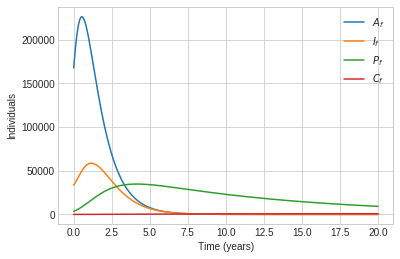

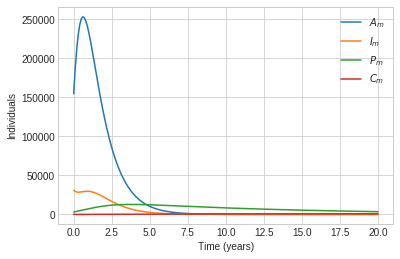

In [9]:
# Plotting prevalence for males and females under control
plt.style.use('seaborn-whitegrid')

#plot females
plt.figure()
plt.plot(t, State0[4,:], label='$A_{f}$')
plt.plot(t, State0[6,:], label='$I_{f}$')
plt.plot(t, State0[8,:], label='$P_{f}$')
plt.plot(t, State0[11,:], label='$C_{f}$')
plt.legend(loc='best')
plt.xlabel('Time (years)')
plt.ylabel('Individuals')
plt.show()

#plot males
plt.figure()
plt.plot(t, State0[5,:], label='$A_{m}$')
plt.plot(t, State0[7,:], label='$I_{m}$')
plt.plot(t, State0[9,:], label='$P_{m}$')
plt.plot(t, State0[11,:], label='$C_{m}$')
plt.legend(loc='best')
plt.xlabel('Time (years)')
plt.ylabel('Individuals')
plt.show()

Text(0.5, 1.0, 'Scenario I')

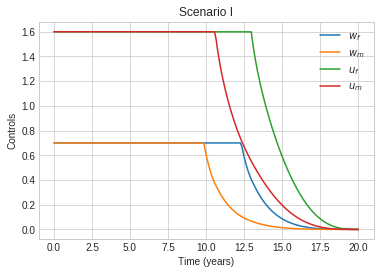

In [10]:
plt.plot(t,Control0[0,:], t,Control0[1,:],t,Control0[2,:],t,Control0[3,:])
plt.legend(['$w_f$','$w_m$','$u_f$', '$u_m$'])
plt.ylabel('Controls')
plt.xlabel('Time (years)')
plt.title('Scenario I')


### Control scenario II

In [11]:
# Max Control
uMax = [0.7, 0.7, 1.60, 1.60]

# Weight parameters
A1 = 1e5
A2 = 1e5
A3 = 1e5
A4 = 1e5

# Scenario 1
B1 = 1e5    # B1*If
B2 = B1/2    # B2*Im
B3 = 8*B1 # B3*Pf
B4 = B3/2    # B4*Pm
B5 = 6*B3 # B5*Cf
B6 = B5/2    # B6*Cm

u1 = np.zeros(NN)
u2 = np.zeros(NN)
u3 = np.zeros(NN)
u4 = np.zeros(NN)

Control0 = np.array([u1, u2, u3, u4])

Adjoint0 = np.zeros_like(State0) 

Sf0ar = np.zeros(NN)
Sf0ar[0] = Sf0

Sm0ar = np.zeros(NN)
Sm0ar[0] = Sm0

Vf0ar = np.zeros(NN)
Vf0ar[0] = Vf0

Vm0ar = np.zeros(NN)
Vm0ar[0] = Vm0

Af0ar = np.zeros(NN)
Af0ar[0] = Af0

Am0ar = np.zeros(NN)
Am0ar[0] = Am0

If0ar = np.zeros(NN)
If0ar[0] = If0

Im0ar = np.zeros(NN)
Im0ar[0] = Im0

Pf0ar = np.zeros(NN)
Pf0ar[0] = Pf0

Pm0ar = np.zeros(NN)
Pm0ar[0] = Pm0

Cf0ar = np.zeros(NN)
Cf0ar[0] = Cf0

Cm0ar = np.zeros(NN)
Cm0ar[0] = Cm0

State0 = np.array([Sf0ar, Sm0ar, Vf0ar, Vm0ar, 
                   Af0ar, Am0ar, If0ar, Im0ar, 
                   Pf0ar, Pm0ar, Cf0ar, Cm0ar])

u1 = np.zeros(NN)
u2 = np.zeros(NN)
u3 = np.zeros(NN)
u4 = np.zeros(NN)

Control0 = np.array([u1, u2, u3, u4])

Adjoint0 = np.zeros_like(State0) 

test=-1
iteration=0
tolerance=1e-3
maxIterations=1000

while(test<0):
    iteration+=1 

    oldControl = Control0
    oldState   = State0
    oldAdjoint = Adjoint0

    # Solution (forward) for State Variables
    State0  = runge_forward(State0, Control0)

    # Solution (backward) for adjoints
    Adjoint0 = runge_backward(State0, Control0, Adjoint0)

    # Control actualization
    Control0 = control_new(State0, Adjoint0, Control0, iteration, uMax)

    # Checking convergence
    errorControl = np.linalg.norm(Control0-oldControl)
    errorState   = np.linalg.norm(State0-oldState)
    errorL       = np.linalg.norm(Adjoint0-oldAdjoint)
    errorMax     = (errorControl+errorState+errorL)/3.

    if errorMax < tolerance:
        test = 1
        print('')
        print('Number of iterations until convergence:', iteration)
    elif iteration == maxIterations:
        test = 1
        print('')
        print('Failure in convergence.')


Number of iterations until convergence: 71


Text(0.5, 1.0, 'Scenario II')

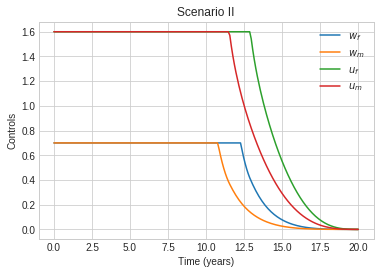

In [12]:
plt.plot(t,Control0[0,:], t,Control0[1,:],t,Control0[2,:],t,Control0[3,:])
plt.legend(['$w_f$','$w_m$','$u_f$', '$u_m$'])
plt.ylabel('Controls')
plt.xlabel('Time (years)')
plt.title('Scenario II')


# Control scenario III

In [13]:
# Max Control
uMax = [0.7, 0.7, 1.60, 1.60]

# Weight parameters
A1 = 1e5
A2 = 1e5
A3 = 1e5
A4 = 1e5

# Scenario 1
B1 = 1e5    # B1*If
B2 = B1    # B2*Im
B3 = 8*B1 # B3*Pf
B4 = B3    # B4*Pm
B5 = 6*B3 # B5*Cf
B6 = B5    # B6*Cm

u1 = np.zeros(NN)
u2 = np.zeros(NN)
u3 = np.zeros(NN)
u4 = np.zeros(NN)

Control0 = np.array([u1, u2, u3, u4])

Adjoint0 = np.zeros_like(State0) 

Sf0ar = np.zeros(NN)
Sf0ar[0] = Sf0

Sm0ar = np.zeros(NN)
Sm0ar[0] = Sm0

Vf0ar = np.zeros(NN)
Vf0ar[0] = Vf0

Vm0ar = np.zeros(NN)
Vm0ar[0] = Vm0

Af0ar = np.zeros(NN)
Af0ar[0] = Af0

Am0ar = np.zeros(NN)
Am0ar[0] = Am0

If0ar = np.zeros(NN)
If0ar[0] = If0

Im0ar = np.zeros(NN)
Im0ar[0] = Im0

Pf0ar = np.zeros(NN)
Pf0ar[0] = Pf0

Pm0ar = np.zeros(NN)
Pm0ar[0] = Pm0

Cf0ar = np.zeros(NN)
Cf0ar[0] = Cf0

Cm0ar = np.zeros(NN)
Cm0ar[0] = Cm0

State0 = np.array([Sf0ar, Sm0ar, Vf0ar, Vm0ar, 
                   Af0ar, Am0ar, If0ar, Im0ar, 
                   Pf0ar, Pm0ar, Cf0ar, Cm0ar])

u1 = np.zeros(NN)
u2 = np.zeros(NN)
u3 = np.zeros(NN)
u4 = np.zeros(NN)

Control0 = np.array([u1, u2, u3, u4])

Adjoint0 = np.zeros_like(State0) 

test=-1
iteration=0
tolerance=1e-3
maxIterations=1000

while(test<0):
    iteration+=1 

    oldControl = Control0
    oldState   = State0
    oldAdjoint = Adjoint0

    # Solution (forward) for State Variables
    State0  = runge_forward(State0, Control0)

    # Solution (backward) for adjoints
    Adjoint0 = runge_backward(State0, Control0, Adjoint0)

    # Control actualization
    Control0 = control_new(State0, Adjoint0, Control0, iteration, uMax)

    # Checking convergence
    errorControl = np.linalg.norm(Control0-oldControl)
    errorState   = np.linalg.norm(State0-oldState)
    errorL       = np.linalg.norm(Adjoint0-oldAdjoint)
    errorMax     = (errorControl+errorState+errorL)/3.

    if errorMax < tolerance:
        test = 1
        print('')
        print('Number of iterations until convergence:', iteration)
    elif iteration == maxIterations:
        test = 1
        print('')
        print('Failure in convergence.')


Number of iterations until convergence: 71


Text(0.5, 1.0, 'Scenario III')

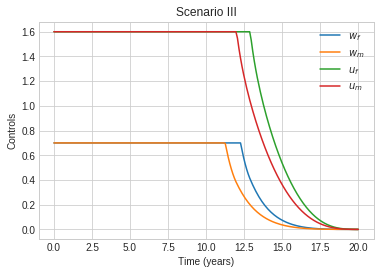

In [14]:
plt.plot(t,Control0[0,:], t,Control0[1,:],t,Control0[2,:],t,Control0[3,:])
plt.legend(['$w_f$','$w_m$','$u_f$', '$u_m$'])
plt.ylabel('Controls')
plt.xlabel('Time (years)')
plt.title('Scenario III')
